### **Import Libraries**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### **Set Constant Values**

In [2]:
BATCH = 64
AT = tf.data.AUTOTUNE
BUFFER = 1000

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH
INITIAL_EPOCHS = 50
FINE_TUNE_EPOCHS = 150

TRAIN_DATASET_PATH = "/kaggle/input/people-clothing-segmentation/png_images/IMAGES/"
VALIDATION_DATASET_PATH = "/kaggle/input/people-clothing-segmentation/png_masks/MASKS/"

### **A Dataset Loader class for converting the dataset into a training dataset and validation dataset**

In [3]:
class DatasetLoader():
    def __init__(self):
      pass

    '''
      Load images and masks from the dataset

      @param images_path - path to the images
      @param masks_path - path to the masks
      @return train_dataset - train dataset
      @return validation_dataset - validation dataset
    '''
    def load_images_and_masks(self, images_path, masks_path):
      image_paths = []
      mask_paths = []

      # Put the images paths into a list
      for root, dir, files in os.walk(images_path):
        for file in files:
          path = os.path.join(root, file)
          image_paths.append(path)

      # Put the masks paths into a list
      for root, dir, files in os.walk(masks_path):
        for file in files:
          path = os.path.join(root, file)
          mask_paths.append(path)

      # Sort the lists into their correct orders
      image_paths.sort()
      mask_paths.sort()

      # Convert images and masks to tensors
      images, masks = self._convert_images_masks_to_tensors(image_paths, mask_paths)

      # Normalize images
      images = self._normalize_images(images)

      # Resize images and masks
      images, masks = self._resize_images_and_masks(images, masks)

      # Split dataset into train and validation
      train_dataset, validation_dataset = self._train_test_split_dataset(images, masks)

      return train_dataset, validation_dataset

    '''
      Convert images and masks to tensors

      @param image_paths - list of image paths
      @param mask_paths - list of mask paths
      @return images - list of images
      @return masks - list of masks
    '''
    def _convert_images_masks_to_tensors(self, image_paths, mask_paths):
      images = []
      masks = []

      # Convert images to tensors
      for image in image_paths:
        image = tf.io.read_file(image)
        image = tf.image.decode_png(image, channels=3, dtype=tf.uint8)
        images.append(image)

      # Convert masks to tensors
      for mask in mask_paths:
        mask = tf.io.read_file(mask)
        mask = tf.image.decode_png(mask, channels=1, dtype=tf.uint8)
        masks.append(mask)

      return images, masks

    '''
      Split dataset into train and validation

      @param images - list of images
      @param masks - list of masks
      @return train_dataset - train dataset
      @return validation_dataset - validation dataset
    '''
    def _train_test_split_dataset(self, images, masks):
      train_X, validation_X, train_y, validation_y = train_test_split(images, masks, test_size=0.2, random_state=42)

      # Convert train and validation datasets to tensors
      train_X = tf.data.Dataset.from_tensor_slices(train_X)
      train_y = tf.data.Dataset.from_tensor_slices(train_y)

      # Convert the validation datasets to tensors
      validation_X = tf.data.Dataset.from_tensor_slices(validation_X)
      validation_y = tf.data.Dataset.from_tensor_slices(validation_y)

      # create a 1-1 mapping from X -> y
      train_dataset = tf.data.Dataset.zip(train_X, train_y)
      validation_dataset = tf.data.Dataset.zip(validation_X, validation_y)

      return train_dataset, validation_dataset

    '''
      Normalize input images

      @param images - list of images
      @return image_list - list of normalized images
    '''
    def _normalize_images(self, images):
      image_list = []
      for image in images:
        image = tf.cast(image, tf.float32)
        image = image / 255.0
        image_list.append(image)

      return image_list

    '''
      Resize images and masks

      @param images - list of images
      @param masks - list of masks
      @return image_list - list of resized images
      @return mask_list - list of resized masks
    '''
    def _resize_images_and_masks(self, images, masks):
      image_list = []
      mask_list = []

      for image in images:
        image = tf.image.resize(image, (128, 128))
        image_list.append(image)

      for mask in masks:
        mask = tf.cast(mask, tf.uint8)
        mask = tf.image.resize(mask, (128, 128),
                                      method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        mask_list.append(mask)

      return image_list, mask_list

### An Augment Dataset for augmented datasets

In [4]:
class AugmentDataset():
    def __init__(self):
      pass

    '''
      Augment dataset

      @param image_dataset - image dataset
      @return image_dataset - augmented image dataset
    '''
    def augment_dataset(self, image_dataset):
      a = image_dataset.map(self._brightness)
      b = image_dataset.map(self._contrast)
      c = image_dataset.map(self._saturation)
      d = image_dataset.map(self._hue)
      e = image_dataset.map(self._crop)
      f = image_dataset.map(self._flip)
      g = image_dataset.map(self._rotate)

      # Concatenate all augmented datasets to return a dataset 7X larger
      image_dataset = image_dataset.concatenate(a)
      image_dataset = image_dataset.concatenate(b)
      image_dataset = image_dataset.concatenate(c)
      image_dataset = image_dataset.concatenate(d)
      image_dataset = image_dataset.concatenate(e)
      image_dataset = image_dataset.concatenate(f)
      image_dataset = image_dataset.concatenate(g)

      return image_dataset

    '''
      Adjust an image's brightness

      @param image - image
      @return bright adjusted image
    '''
    def _brightness(self, image, mask):
        image = tf.image.adjust_brightness(image, 0.1)
        return image, mask

    '''
      Adjust an image and mask's contrast

      @param image - image
      @param mask - mask
      @return contrast adjusted image
      @return contrast adjusted mask
    '''
    def _contrast(self, image, mask):
        image = tf.image.adjust_contrast(image, 0.1)
        return image, mask

    '''
      Adjust an image and mask's saturation

      @param image - image
      @param mask - mask
      @return saturation adjusted image
      @return saturation adjusted mask
    '''
    def _saturation(self, image, mask):
        image = tf.image.adjust_saturation(image, 0.1)
        return image, mask

    '''
      Adjust an image and mask's hue

      @param image - image
      @param mask - mask
      @return hue adjusted image
      @return hue adjusted mask
    '''
    def _hue(self, image, mask):
        image = tf.image.adjust_hue(image, 0.1)
        return image, mask

    '''
      Crop an image and mask

      @param image - image
      @param mask - mask
      @return cropped image
      @return cropped mask
    '''
    def _crop(self, image, mask):
      tf.image.central_crop(image, 0.7)
      tf.image.resize(image, (128, 128))

      mask = tf.image.central_crop(mask, 0.7)
      mask = tf.image.resize(mask, (128,128))
      mask = tf.cast(mask, tf.uint8)

      return image, mask

    '''
      Flip an image and mask

      @param image - image
      @param mask - mask
      @return flipped image
      @return flipped mask
    '''
    def _flip(self, image, mask):
      image = tf.image.flip_left_right(image)
      mask = tf.image.flip_left_right(mask)
      return image, mask

    '''
      Rotate an image and mask

      @param image - image
      @param mask - mask
      @return rotated image
      @return rotated mask
    '''
    def _rotate(self, image, mask):
      image = tf.image.rot90(image)
      mask = tf.image.rot90(mask)
      return image, mask

### The Model Builder creates a modified UNet Model using a concatenation of a downsampler (MobileNetV2) and an upsampler

In [5]:
class ModelBuilder():
    def __init__(self):
      self.down_sampling_model = None
      self.unet_model = None

    '''
      Create a unet model

      @return unet model
    '''
    def build_unet_model(self):
      # create the upsampling model using a combination of upsampling models
      upsampling_model = [
          self.build_upsampling_model(512, 4),
          self.build_upsampling_model(256, 4),
          self.build_upsampling_model(128, 4),
          self.build_upsampling_model(64, 4)
      ]

      # create the input layer using the shape of the images
      inputs = tf.keras.layers.Input(shape=[128, 128, 3])

      self.down_sampling_model = self.build_down_sampling_model()

      # store the results of the inputs going through the downsampling model
      down_sample = self.down_sampling_model(inputs)

      # store the last layer result as an output
      output = down_sample[-1]

      # store every output from the downsampling layer except the last one
      skips = reversed(down_sample[:-1])

      # loop through the upsampling model and the skips and concatenate them
      for upsample, skip in zip(upsampling_model, skips):
        output = upsample(output)
        output = tf.keras.layers.Concatenate()([output, skip])

      # downsample the output to get 59 mask potential values
      output = tf.keras.layers.Conv2DTranspose(
          filters=59,
          kernel_size=3,
          strides=2,
          padding='same')(output)

      # create and compile the UNET model
      self.unet_model = tf.keras.Model(inputs=inputs, outputs=output)
      self.compile_unet_model()

      return self.unet_model

    '''
      Compile a unet model
    '''
    def compile_unet_model(self):
      self.unet_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
        metrics=['accuracy'])

    '''
      Create a fine-tuned unet model

      @return fine-tuned unet model
    '''
    def build_fine_tuned_unet_model(self):
      # enable training for the down_sampling_model (MobileNetV2)
      self.down_sampling_model.trainable = True

      # recompile the model
      self.compile_unet_model()

      return self.unet_model

    '''
      Create a down-sampling model

      @return down-sampling model
    '''
    def build_down_sampling_model(self):
      # using MobileNetV2 but any other choice could probably work here
      base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights="imagenet")

      # Looking through the MobileNetV2 plot_model I found these blocks that
      # fit the needs of the down_sampling_model.
      skip_layer_names = [
          "block_1_expand_relu", # 128 -> 64
          "block_2_expand_relu", # 64 -> 32
          "block_5_expand_relu", # 32 -> 16
          "block_8_expand_relu", # 16 -> 8
          "block_14_expand_relu", # 8 -> 4
      ]

      # get the skip layers from the base model using the layer names
      skip_layers = [base_model.get_layer(name).output for name in skip_layer_names]

      # create the down_sampling model with the base model having training disabled
      down_stack = tf.keras.Model(inputs=base_model.input, outputs=skip_layers)
      down_stack.trainable = False

      return down_stack

    '''
      Create an up-sampling model

      @param filters - number of filters
      @param size - size of the kernel
      @return up-sampling model
    '''
    def build_upsampling_model(self, filters, size):
      initializer = tf.random_normal_initializer(0., 0.02)

      upsampling_model = tf.keras.Sequential()
      upsampling_model.add(tf.keras.layers.Conv2DTranspose(
          filters, size, strides=2,
          padding='same',
          kernel_initializer=initializer,
          use_bias=False))

      upsampling_model.add(tf.keras.layers.BatchNormalization())
      upsampling_model.add(tf.keras.layers.ReLU())

      return upsampling_model

### An Image Viewer class for plotting images

In [6]:
class ImageViewer():
    def __init__(self):
      pass

    '''
      Show images and masks from a dataset

      @param dataset - dataset to containg images and masks to display
      @param num_to_show - an even number of images to show (default is 2)
    '''
    def show_from_dataset(self, dataset, num_to_show=2):
      plt.figure(figsize=(15,15))

      for image, mask in dataset.take(1):
        for i in range(num_to_show):
          if (i % 2) == 0:
            plt.subplot(1,2,i+1)
            plt.imshow(image)
            plt.axis('off')
          else:
            plt.subplot(1,2,i+1)
            plt.imshow(mask)
            plt.axis("off")
            plt.show()

    '''
      Plot two images side-by-side
      @param image1 -image 1
      @param image2 - image 2
    '''
    def plot_two_images(self, image1, image2):
      plt.figure(figsize=(15,15))
      plt.subplot(1,2, 1)
      plt.imshow(image1)
      plt.axis('off')

      plt.subplot(1,2, 2)
      plt.imshow(image2)
      plt.axis("off")
      plt.show()

    '''
      Show prediction

      @param image - image
      @param mask - mask
      @param pred - prediction
    '''
    def show_pred(self, image, mask, pred):
        plt.figure(figsize=(20,28))

        k = 0
        for i in pred:
            # show the predicted mask
            plt.subplot(4,3,1+k*3)
            i = tf.argmax(i, axis=-1)
            plt.imshow(i)
            plt.axis('off')
            plt.title('Prediction')

            # show the groundtruth mask
            plt.subplot(4,3,2+k*3)
            plt.imshow(mask[k])
            plt.axis('off')
            plt.title('Ground Truth')

            # show the real image
            plt.subplot(4,3,3+k*3)
            plt.imshow(image[k])
            plt.axis('off')
            plt.title('Actual')
            k += 1
            if k == 4: break

        plt.suptitle('Preditions', color='blue', size=24)
        plt.show()

### A Performance Report class for plotting the performance of the model

In [7]:
class PerformanceReport():
    def __init__(self):
      self.conf_matrix = None

    '''
      Plot the UNET model's loss performance

      @param model_history - the unet model history
    '''
    def plot_loss_performance_charts(self, model_history):
      loss = model_history.history['loss']
      val_loss = model_history.history['val_loss']

      plt.figure()
      plt.plot(model_history.epoch, loss, 'r', label='Training loss')
      plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
      plt.title('Training and Validation Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss Value')
      plt.ylim([0.5, 1])
      plt.legend()
      plt.show()

    '''
      Plot the UNET model's accuracy performance

      @param model_history - the unet model history
    '''
    def plot_accuracy_performance_charts(self, model_history):
      loss = model_history.history['accuracy']
      val_loss = model_history.history['val_accuracy']

      plt.figure()
      plt.plot(model_history.epoch, loss, 'r', label='Training Accuracy')
      plt.plot(model_history.epoch, val_loss, 'bo', label='Validation Accuracy')
      plt.title('Training and Validation Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy Value')
      plt.ylim([0.5, 1])
      plt.legend()
      plt.show()

    '''
      Display a confusion matrix

      @param y_true - true labels
      @param y_pred - predicted labels
    '''
    def display_confusion_matrix(self, y_true, y_pred):
      self.conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

      # plot the confusion matrix
      fig, ax = plt.subplots(figsize=(7.5, 7.5))
      ax.matshow(self.conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
      for i in range(self.conf_matrix.shape[0]):
          for j in range(self.conf_matrix.shape[1]):
              ax.text(x=j, y=i,s=self.conf_matrix[i, j], va='center', ha='center', size='xx-large')

      plt.xlabel('Predictions', fontsize=14)
      plt.ylabel('Actuals', fontsize=14)
      plt.title('Confusion Matrix', fontsize=18)
      plt.show()

      # Show the confusion matrix results in a text report
      self._show_confusion_matrix_report()

      '''
        Display the results of the confusion matrix as a text report
      '''
      def _show_confusion_matrix_report(self):
        tn, fp, fn, tp = self.conf_matrix.ravel()

        print("True Positive (TP): ", tp)
        print("True Negative (TN): ", tn)
        print("False Positive (FP): ", fp)
        print("False Negative (FN): ", fn)

        accuracy = (tp + tn) / (tp + tn + fp + fn)

        precision = tp / (tp + fp)

        recall = tp / (tp + fn)

        f1_score = 2 * (precision * recall) / (precision + recall)

        print("\n\nMetrics:")
        print("Accuracy: ", round(accuracy, 2))
        print("Precision: ", round(precision, 2))
        print("Recall: ", round(recall, 2))
        print("F1-score: ", round(f1_score, 2))

#### Start by loading the images and masks into a training_dataset and validation_dataset

In [8]:
dataset_loader = DatasetLoader()
train_dataset, validation_dataset = dataset_loader.load_images_and_masks(TRAIN_DATASET_PATH, VALIDATION_DATASET_PATH)

#### Verify an image and corresponding mask from the training set

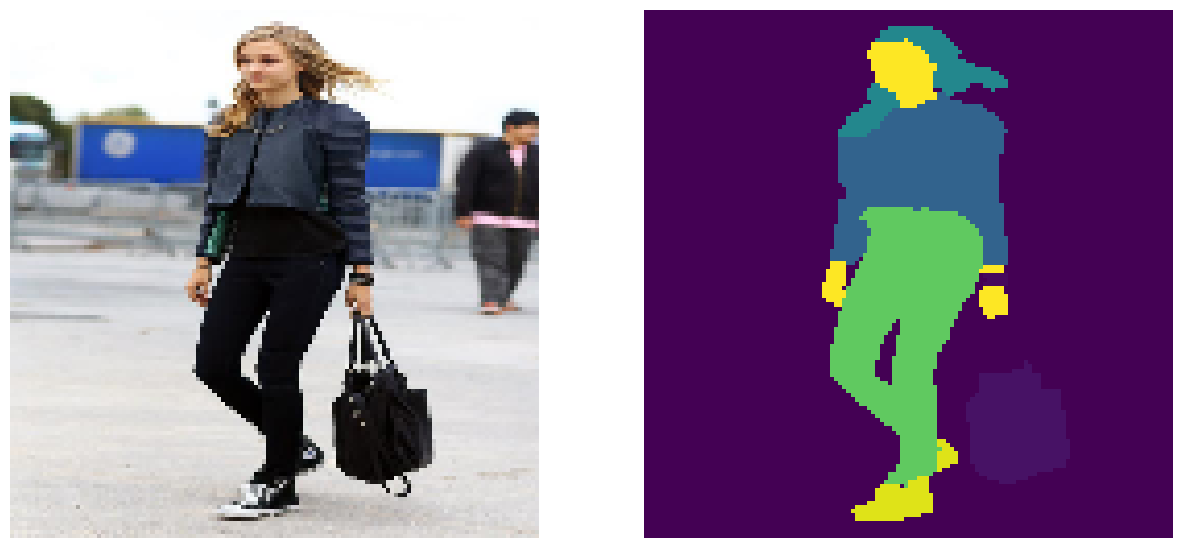

In [9]:
image_viewer = ImageViewer()
image_viewer.show_from_dataset(train_dataset)

#### Augment the training dataset to create 7X more training data

In [10]:
augment_dataset = AugmentDataset()
train_dataset = augment_dataset.augment_dataset(train_dataset)

print("Training Dataset: ", len(train_dataset))
print("Training Dataset #:", train_dataset.element_spec)

Training Dataset:  6400
Training Dataset #: (TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))


#### Build the modified UNet model